<a href="https://colab.research.google.com/github/fjadidi2001/fake_news_detection/blob/main/fake_news_detection_GAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================================
# STEP 1: SETUP AND IMPORTS
# ==========================================

# Install dependencies
!pip install torch-geometric imbalanced-learn -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from scipy import io as sio
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.1 MB/s eta 0:00:00
✅ All libraries imported successfully!


Mounted at /content/drive
Dataset shape: (2282, 13)
Columns: ['account_id', 'post_id', 'Category', 'Page', 'Post URL', 'Date Published', 'Post Type', 'Rating', 'Debate', 'share_count', 'reaction_count', 'comment_count', 'Context Post']
First 5 rows:
     account_id       post_id    Category               Page  \
0  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
1  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
2  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
3  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   
4  1.840000e+14  1.040000e+15  mainstream  ABC News Politics   

                                            Post URL Date Published Post Type  \
0  https://www.facebook.com/ABCNewsPolitics/posts...      9/19/2016     video   
1  https://www.facebook.com/ABCNewsPolitics/posts...      9/19/2016      link   
2  https://www.facebook.com/ABCNewsPolitics/posts...      9/19/2016      link   
3  https://www.facebook.com/ABCNewsPoliti

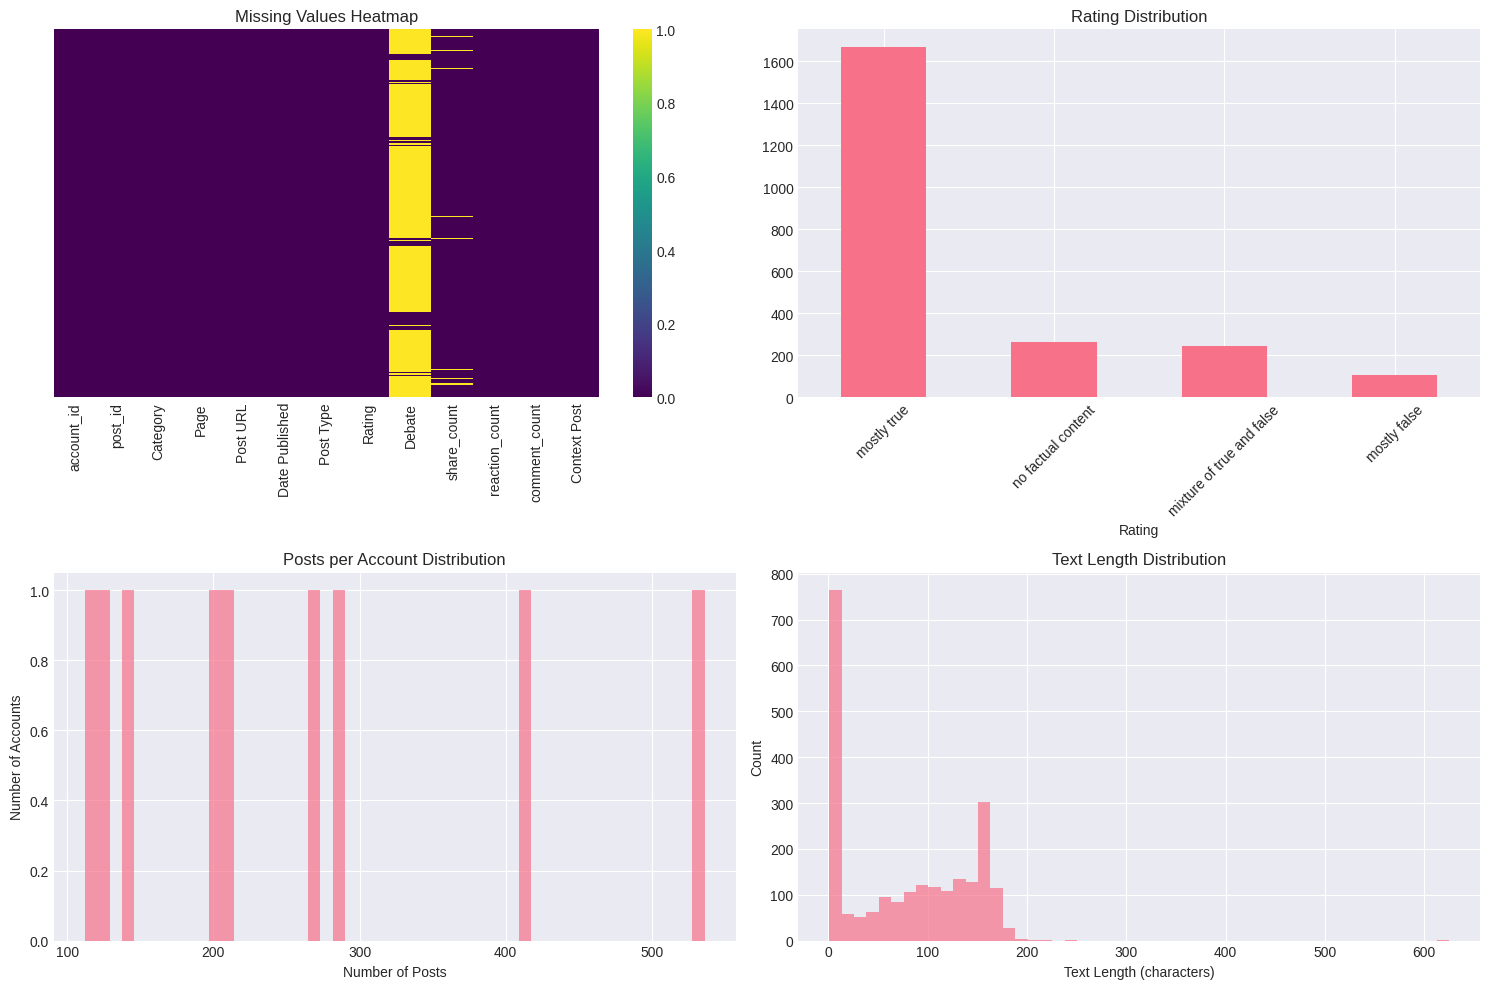

In [2]:
# ==========================================
# STEP 2: DATA LOADING AND INITIAL EXPLORATION
# ==========================================

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Projects/Hayat/facebook-fact-check.csv', encoding='latin-1')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"First 5 rows:")
print(df.head())

# Basic statistics
print(f"\nDataset Info:")
print(f"Number of samples: {len(df)}")
print(f"Number of features: {df.shape[1]}")
print(f"Missing values per column:")
print(df.isnull().sum())

# Visualize dataset overview
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Missing values heatmap
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis', ax=axes[0,0])
axes[0,0].set_title('Missing Values Heatmap')

# 2. Rating distribution
df['Rating'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Rating Distribution')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Account activity distribution
account_counts = df['account_id'].value_counts()
axes[1,0].hist(account_counts.values, bins=50, alpha=0.7)
axes[1,0].set_title('Posts per Account Distribution')
axes[1,0].set_xlabel('Number of Posts')
axes[1,0].set_ylabel('Number of Accounts')

# 4. Text length distribution
text_lengths = df['Context Post'].fillna('').str.len()
axes[1,1].hist(text_lengths, bins=50, alpha=0.7)
axes[1,1].set_title('Text Length Distribution')
axes[1,1].set_xlabel('Text Length (characters)')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

✅ Network features preprocessed
Raw features shape: (2282, 3)
Processed features shape: (2282, 3)


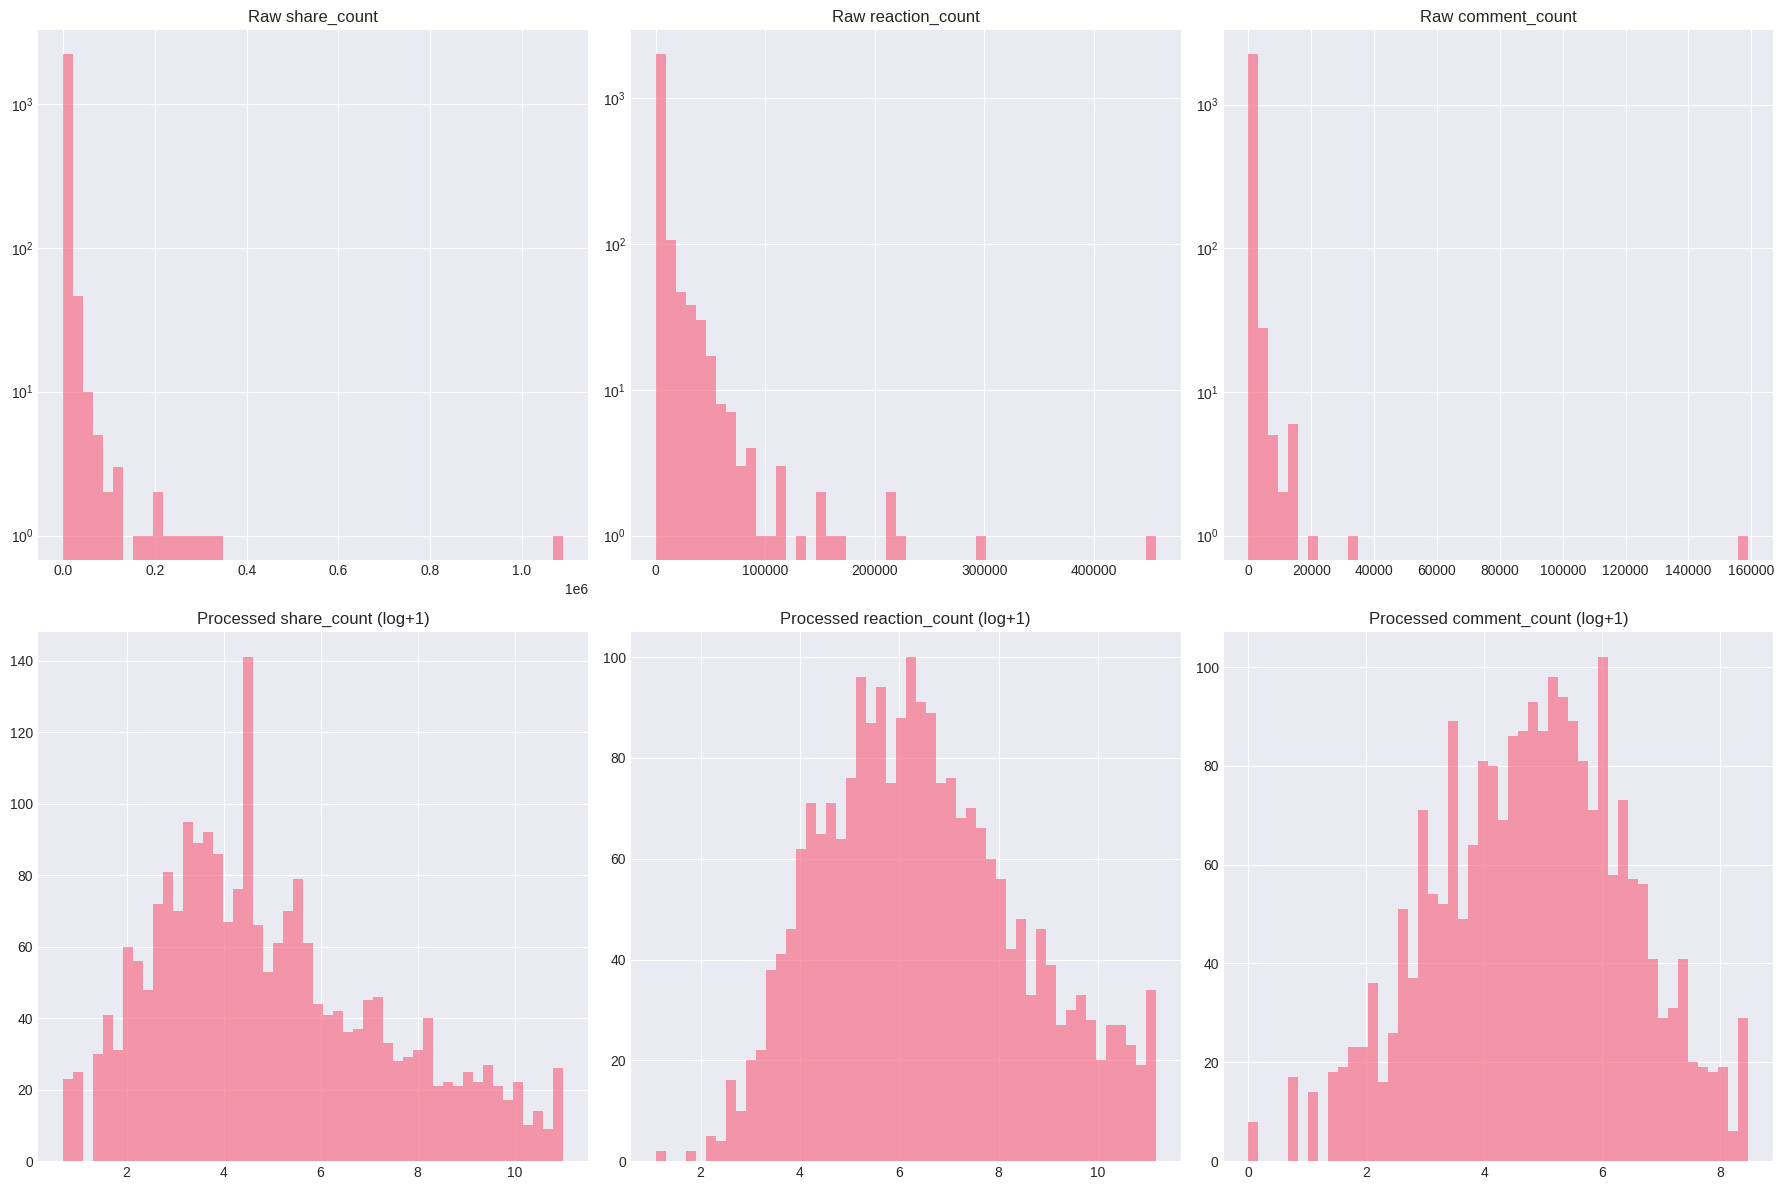

Standardized features shape: (2282, 3)
NaN check: False


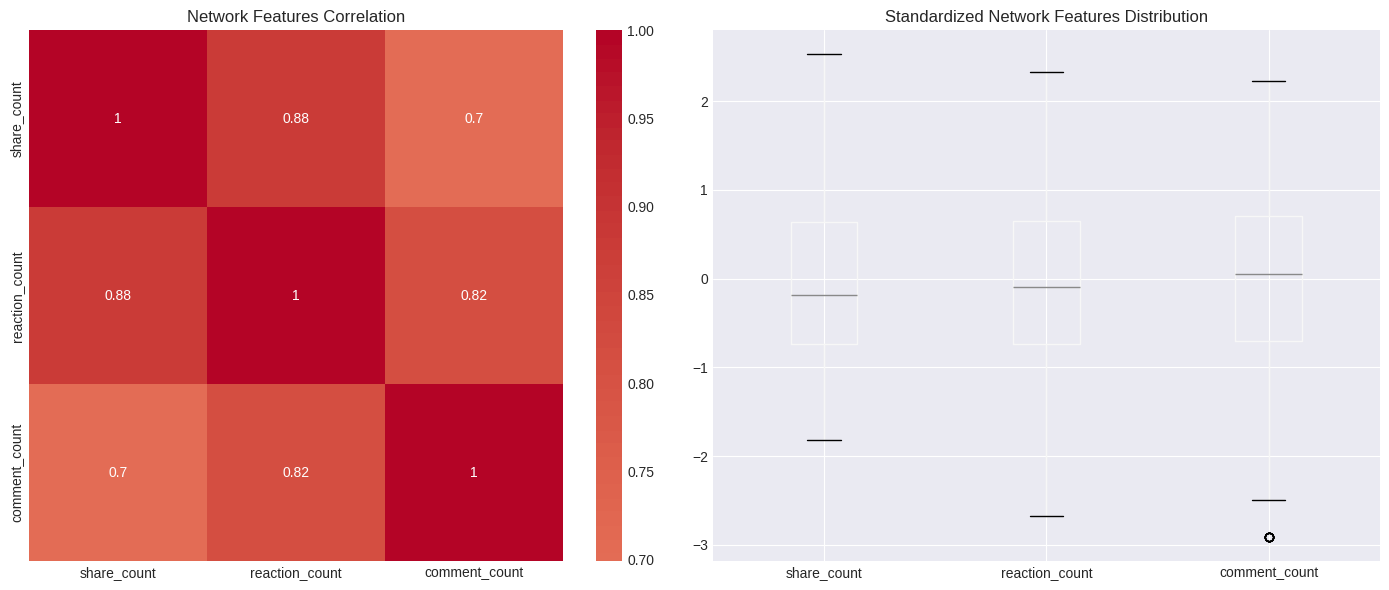

In [3]:
# ==========================================
# STEP 3: NETWORK FEATURES PREPROCESSING
# ==========================================

def preprocess_network_features(df):
    """Enhanced preprocessing with outlier handling and normalization"""
    # Extract network features
    network_cols = ['share_count', 'reaction_count', 'comment_count']
    features = df[network_cols].copy()

    # Handle missing values
    features = features.fillna(features.median())


    # Log transform to handle skewness (add 1 to avoid log(0))
    features_log = np.log1p(features)

    # Optional: Cap extreme outliers at 99th percentile
    for col in features_log.columns:
        q99 = features_log[col].quantile(0.99)
        features_log[col] = features_log[col].clip(upper=q99)

    return features_log.values, features.values

# Preprocess network features
network_features_processed, network_features_raw = preprocess_network_features(df)

print("✅ Network features preprocessed")
print(f"Raw features shape: {network_features_raw.shape}")
print(f"Processed features shape: {network_features_processed.shape}")

# Visualize network features preprocessing
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Raw features
for i, col in enumerate(['share_count', 'reaction_count', 'comment_count']):
    axes[0, i].hist(network_features_raw[:, i], bins=50, alpha=0.7)
    axes[0, i].set_title(f'Raw {col}')
    axes[0, i].set_yscale('log')

    axes[1, i].hist(network_features_processed[:, i], bins=50, alpha=0.7)
    axes[1, i].set_title(f'Processed {col} (log+1)')

plt.tight_layout()
plt.show()

# Standardize network features
scaler = StandardScaler()
X_net_std = scaler.fit_transform(network_features_processed)

print(f"Standardized features shape: {X_net_std.shape}")
print(f"NaN check: {np.isnan(X_net_std).any()}")

# Save for later use
sio.savemat('/content/drive/MyDrive/Projects/Hayat/network_processed.mat', {
    'X_net_std': X_net_std,
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_
})

# Visualize correlation and distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation heatmap
corr_matrix = pd.DataFrame(X_net_std, columns=['share_count', 'reaction_count', 'comment_count']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Network Features Correlation')

# Distribution after standardization
pd.DataFrame(X_net_std, columns=['share_count', 'reaction_count', 'comment_count']).boxplot(ax=axes[1])
axes[1].set_title('Standardized Network Features Distribution')

plt.tight_layout()
plt.show()

Label distribution: [1669  613]
Class 0 (mostly true): 1669 (73.1%)
Class 1 (others): 613 (26.9%)


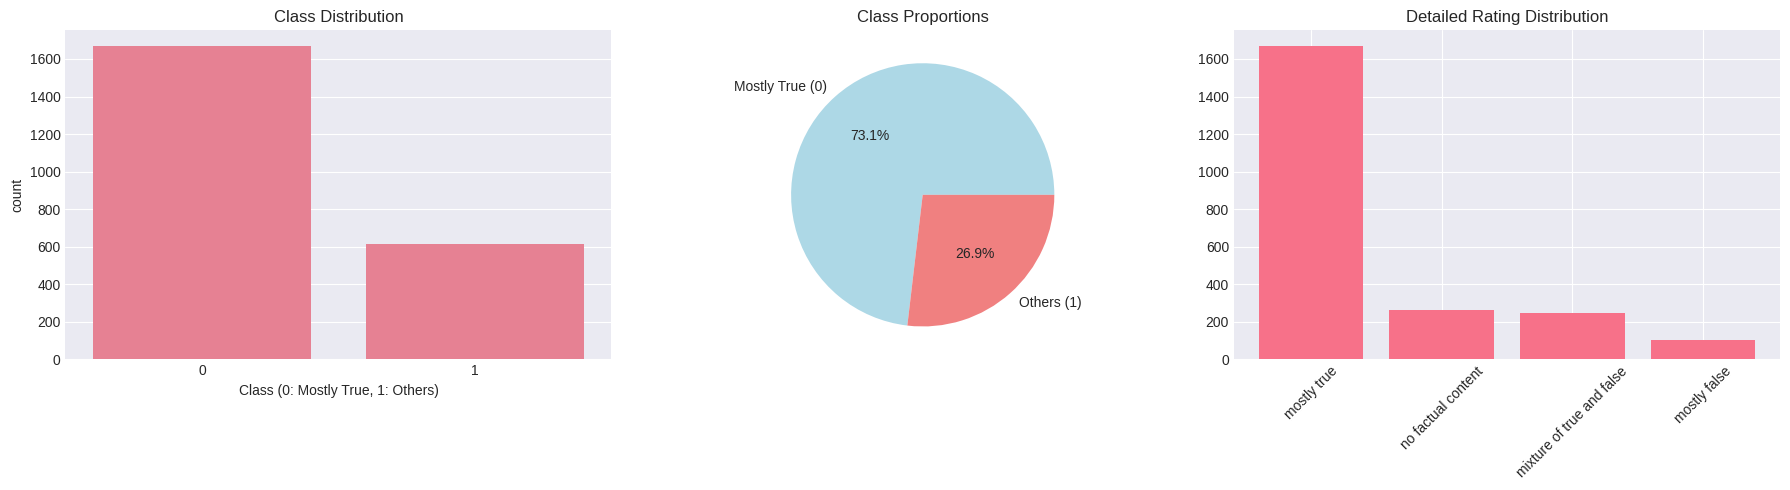

In [4]:
# ==========================================
# STEP 4: LABEL PREPARATION AND ANALYSIS
# ==========================================

# Prepare labels (binary classification)
labels = df['Rating'].apply(lambda x: 0 if x == 'mostly true' else 1).values
y = np.array(labels)

print(f"Label distribution: {np.bincount(y)}")
print(f"Class 0 (mostly true): {np.bincount(y)[0]} ({np.bincount(y)[0]/len(y)*100:.1f}%)")
print(f"Class 1 (others): {np.bincount(y)[1]} ({np.bincount(y)[1]/len(y)*100:.1f}%)")

# Visualize label distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Count plot
sns.countplot(x=y, ax=axes[0])
axes[0].set_title("Class Distribution")
axes[0].set_xlabel("Class (0: Mostly True, 1: Others)")

# Pie chart
labels_pie = ['Mostly True (0)', 'Others (1)']
colors = ['lightblue', 'lightcoral']
axes[1].pie(np.bincount(y), labels=labels_pie, autopct='%1.1f%%', colors=colors)
axes[1].set_title("Class Proportions")

# Class distribution by rating
rating_counts = df['Rating'].value_counts()
axes[2].bar(range(len(rating_counts)), rating_counts.values)
axes[2].set_xticks(range(len(rating_counts)))
axes[2].set_xticklabels(rating_counts.index, rotation=45)
axes[2].set_title("Detailed Rating Distribution")

plt.tight_layout()
plt.show()
